# Schrodinger equation
---

$$
\begin{aligned}
\varepsilon u_t - i\frac{\epsilon^2}{2}\Delta u + i V(x)u = 0, \ t \in \mathbb{R}, x\in \mathbb{R}^d, \\
u(x, t = 0) = u_0(x),
\end{aligned}
$$
where $V$ is a given electrostatic potential, $0 < \varepsilon \ll 1$.

---

Example 2 in Shi Jin's paper:
$$
u(x, 0) = \sqrt{n_0(x)}e^{iS_0(x)/\varepsilon},
$$
(3.9-3.10)
$$
n_0(x) = (e^{-25(x-0.5)^2})^2, \ S_0(x) = 0.2(x^2 - x).
$$

Periodic BC.

---

Consider the real and imag part of $u$, i.e., 
$$
u(x, t) = p(x, t) + iq(x, t),
$$
then
$$
\begin{aligned}
&\varepsilon p_t+\frac{\varepsilon^2}{2}q_{xx} - V(x)q = 0, \\
&\varepsilon q_t-\frac{\varepsilon^2}{2}p_{xx} + V(x)p = 0,
\end{aligned}
$$
with ic
$$
p(x, 0) = e^{-25(x-0.5)^2}\cos(\frac{0.2(x^2-x)}{\varepsilon}), \ q(x, 0) = e^{-25(x-0.5)^2}\sin(\frac{0.2(x^2-x)}{\varepsilon}),
$$
and bc
$$
p(0, t) = p(1, t), q(0, t) = q(1, t), p_x(0, t) = p_x(1, t), q_x(0, t) = q_x(1, t).
$$

In [1]:
NAME = "2_tanh"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers

import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple

In [3]:
key = random.PRNGKey(0)
key, subkey = random.split(key, 2)

layers = [2] + [128]*4 + [2] # (x, t) -> (u, v)
c0 = 6.0
w0 = 10.0
w1 = 1.0
lambda_0 = 1e-8
# direct_params = init_siren_params(subkey, layers, c0, w0, w1)
direct_params = init_tanh_params(subkey, layers)

domain = jnp.array([[0., 0.], [1., 1.]])
epsilon = 1.0
V = 1.0

@jax.jit
def model(params, xt):
	# first, normalize to [-1, 1]
	xt = 2.0*(xt - domain[0, :])/(domain[1, :]-domain[0, :]) - 1.0
	for w, b in params[:-1]:
		xt = jnp.tanh(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model)
hessian = hessian_fn(model)

In [4]:
metaloss = mae

jit_conservation = lambda i: jax.partial(jax.jit, static_argnums = i)

@jit_conservation(2)
def loss_fn_(params, batch, conservation):
	collocation, dirichlet, periodic_bc = batch["collocation"], batch["dirichlet"], batch["periodic_bc"]
	direct_params = params
	
	uv_c = model(direct_params, jnp.hstack([collocation.x, collocation.t]))
	u_c, v_c = uv_c[:, 0:1], uv_c[:, 1:2]
	
	# jacobian[i] = [[du/dx, du/dt],
	#                [dv/dx, dv/dt]]
	# i: the i^th input
	duv_dxt_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t]))
	du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
	
	# hessian[i] = [
    #				[[du/dxx, du/dxy],
	#                [du/dxy, du/dyy]],
	#               [[dv/dxx, dv/dxy],
	#                [dv/dxy, dv/dyy]]
	#              ]
	duv_dxxtt_c = hessian(direct_params, jnp.hstack([collocation.x, collocation.t]))
	du_dxx_c, dv_dxx_c = duv_dxxtt_c[:, 0:1, 0, 0], duv_dxxtt_c[:, 1:2, 0, 0] 
	
	uv_l = model(direct_params, jnp.hstack([periodic_bc.l, periodic_bc.t]))
	uv_r = model(direct_params, jnp.hstack([periodic_bc.r, periodic_bc.t]))
	u_l, v_l = uv_l[:, 0:1], uv_l[:, 1:2]
	u_r, v_r = uv_r[:, 0:1], uv_r[:, 1:2]
	
	duv_dxt_l = jacobian(direct_params, jnp.hstack([periodic_bc.l, periodic_bc.t]))
	duv_dxt_r = jacobian(direct_params, jnp.hstack([periodic_bc.r, periodic_bc.t]))
	du_dx_l, dv_dx_l = duv_dxt_l[:, 0:1, 0], duv_dxt_l[:, 1:2, 0]
	du_dx_r, dv_dx_r = duv_dxt_r[:, 0:1, 0], duv_dxt_r[:, 1:2, 0]
		
	uv_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t]))
	u_d, v_d = uv_d[:, 0:1], uv_d[:, 1:2]
	
	uv_conservation = model(direct_params, jnp.hstack([conservation.x, conservation.t]))
	u_conservation, v_conservation = uv_conservation[:, 0:1].reshape((conservation.nt, conservation.nx)), uv_conservation[:, 1:2].reshape((conservation.nt, conservation.nx))
	norm_conservation = jnp.sum(jnp.square(u_conservation)+jnp.square(v_conservation), axis = 1)
	uv0_conservation = model(direct_params, jnp.hstack([conservation.x0, conservation.t0]))
	u0_con, v0_con = uv0_conservation[:, 0:1], uv0_conservation[:, 1:2]
	norm0_con = jnp.sum(jnp.square(u0_con) + jnp.square(v0_con))
	loss_conservation = metaloss(norm_conservation - norm0_con, 0)
	
	duv_dxt_conservation = jacobian(direct_params, jnp.hstack([conservation.x, conservation.t]))
	du_dx_conservation, dv_dx_conservation = duv_dxt_conservation[:, 0:1, 0].reshape((conservation.nt, conservation.nx)), duv_dxt_conservation[:, 1:2, 0].reshape((conservation.nt, conservation.nx))
	energy_conservation = (epsilon**2)/2*jnp.sum(du_dx_conservation**2+dv_dx_conservation**2, axis = 1) # + V*norm_conservation
	duv0_dxt0_conservation = jacobian(direct_params, jnp.hstack([conservation.x0, conservation.t0]))
	du0_dx0_conservation, dv0_dx0_conservation = duv0_dxt0_conservation[:, 0:1, 0], duv0_dxt0_conservation[:, 1:2, 0]
	energy0_conservation = (epsilon**2)/2*jnp.sum(du0_dx0_conservation**2+dv0_dx0_conservation**2) # + V*norm0_con <- included in mass con
	loss_energy = metaloss(energy_conservation - energy0_conservation, 0)
	
	
	loss_c1 = metaloss(epsilon*du_dt_c + 0.5*epsilon**2*dv_dxx_c - V*v_c, 0)
	loss_c2 = metaloss(epsilon*dv_dt_c - 0.5*epsilon**2*du_dxx_c + V*u_c, 0)
	loss_c = loss_c1 + loss_c2
	
	loss_d1 = metaloss(u_d, dirichlet.u)
	loss_d2 = metaloss(v_d, dirichlet.v)
	loss_d = loss_d1 + loss_d2
	
	loss_pbc_d1 = metaloss(u_l, u_r)
	loss_pbc_d2 = metaloss(v_l, v_r)
	loss_pbc_n1 = metaloss(du_dx_l, du_dx_r)
	loss_pbc_n2 = metaloss(dv_dx_l, dv_dx_r)
	loss_pbc_d = loss_pbc_d1 + loss_pbc_d2
	loss_pbc_n = loss_pbc_n1 + loss_pbc_n2
	
	return loss_c, loss_d, loss_pbc_d, loss_pbc_n, loss_conservation, loss_energy


@jit_conservation(2)
def loss_fn(params, batch, conservation):
	w = batch["weights"]
	loss_c, loss_d, loss_pbc_d, loss_pbc_n, loss_conservation, loss_energy = loss_fn_(params, batch, conservation)
	return w["c"]*loss_c + w["d"]*loss_d + w["pbc_d"]*loss_pbc_d + w["pbc_n"]*loss_pbc_n + w["conservation"]*loss_conservation + w["energy"]*loss_energy \
			+ l2_regularization(params, lambda_0)

@jit_conservation(3)
def step(i, opt_state, batch, conservation):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch, conservation)
	return opt_update(i, grad, opt_state)

@jit_conservation(2)
def evaluate(params, batch, conservation):
	w = batch["weights"]
	loss_c, loss_d, loss_pbc_d, loss_pbc_n, loss_conservation, loss_energy = loss_fn_(params, batch, conservation)
	return w["c"]*loss_c + w["d"]*loss_d + w["pbc_d"]*loss_pbc_d + w["pbc_n"]*loss_pbc_n + w["conservation"]*loss_conservation+ w["energy"]*loss_energy, \
			loss_c, loss_d, loss_pbc_d, loss_pbc_n, loss_conservation, loss_energy

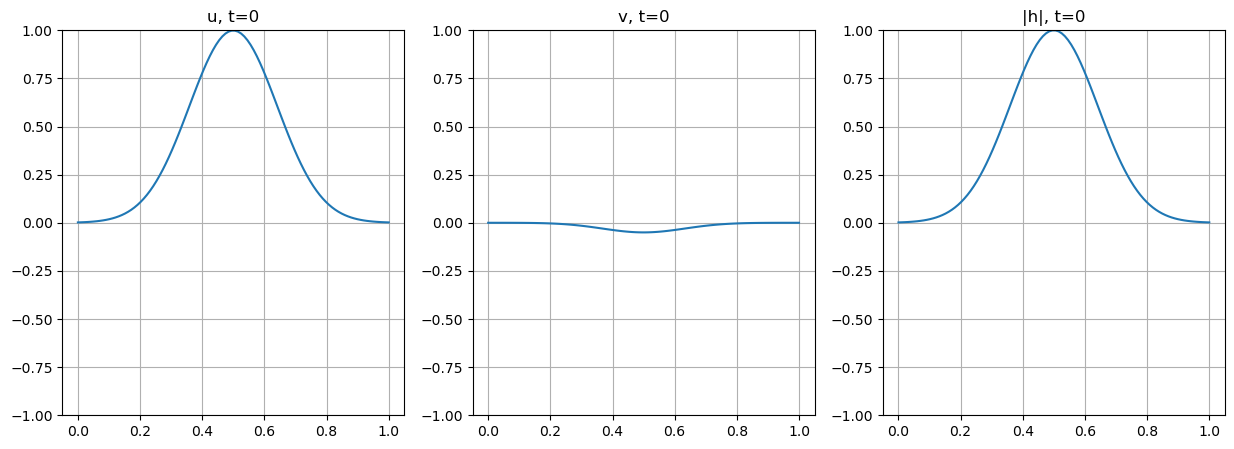

In [5]:
u0_fn = lambda x, t: np.exp(-25*(x-0.5)**2)*np.cos(0.2/epsilon*(x**2-x))
v0_fn = lambda x, t: np.exp(-25*(x-0.5)**2)*np.sin(0.2/epsilon*(x**2-x))
x0 = np.linspace(*domain[:, 0], 100)
t0 = np.zeros_like(x0)
u0 = u0_fn(x0, t0)
v0 = v0_fn(x0, t0)

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

f, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].plot(x0, u0)
ax[0].set_title("u, t=0")
ax[0].grid()
ax[0].set_ylim([-1, 1])
ax[1].plot(x0, v0)
ax[1].set_title("v, t=0")
ax[1].grid()
ax[1].set_ylim([-1, 1])
ax[2].plot(x0, np.sqrt(u0**2+v0**2))
ax[2].set_title("|h|, t=0")
ax[2].grid()
ax[2].set_ylim([-1, 1])
plt.show()

key, *subkeys = random.split(key, 3)

n_i = 10000
x_i = random.uniform(subkeys[0], (n_i, 1), jnp.float32, *domain[:, 0])
t_i = jnp.zeros_like(x_i)
u_i = u0_fn(x_i, t_i)
v_i = v0_fn(x_i, t_i)

n_b = 1000
t_b = random.uniform(subkeys[1], (n_b, 1), jnp.float32, *domain[:, 1])
x_lb = jnp.ones_like(t_b)*domain[0, 0]
x_rb = jnp.ones_like(t_b)*domain[1, 0]

n_cx = 2000
n_ct = 200
x_c = jnp.linspace(*domain[:, 0], n_cx)
t_c = jnp.linspace(*domain[:, 1], n_ct)
xt_c = tensor_grid([x_c, t_c])

nx_conservation = 101
nt_conservation = 50
x_conservation = jnp.linspace(*domain[:, 0], nx_conservation)
t_conservation = jnp.linspace(*domain[:, 1], nt_conservation)
tx_conservation = tensor_grid([t_conservation, x_conservation])
x0_conservation = x_conservation
t0_conservation = jnp.array([domain[0, 1]])
tx0_conservation = tensor_grid([t0_conservation, x0_conservation])

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "u", "v"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t"])
dataset_BC = namedtuple("dataset_BC", ["l", "r", "t"])
dataset_Conservation = namedtuple("dataset_Conservation", ["x", "t", "nx", "nt", "x0", "t0"])

dirichlet = dataset_Dirichlet(x_i, t_i, u_i, v_i)
periodic_bc = dataset_BC(x_lb, x_rb, t_b)
collocation = dataset_Collocation(jnp.vstack([dirichlet.x, periodic_bc.l, periodic_bc.r, xt_c[:, 0:1]]),
								  jnp.vstack([dirichlet.t, periodic_bc.t, periodic_bc.t, xt_c[:, 1:2]]))
conservation = dataset_Conservation(tx_conservation[:, 1:2], tx_conservation[:, 0:1], nx_conservation, nt_conservation, tx0_conservation[:, 1:2], tx0_conservation[:, 0:1])

In [6]:
lr = 1e-3
start_iteration = 0
iterations = 10000
print_every = 200
save_every = 5000
batch_size = {"dirichlet": 10000, "bc": 1000, "collocation": 100000}
weights = {"c": 1.0, "d": 1e4, "pbc_d": 1e4, "pbc_n": 1e4, "conservation": 1.0, "energy": 1.0}

key, *subkeys = random.split(key, 4)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])
BC = Batch_Generator(subkeys[2], periodic_bc, batch_size["bc"])
params = direct_params

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"periodic_bc": dataset_BC(*next(BC)),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch, conservation)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "pbc_d", "pbc_n", "conservation", "energy"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch, conservation)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/06, 22:44:53, Iteration: 0, Train Loss: 1.2000e+04, c: 5.0769e-01, d: 4.2875e-01, pbc_d: 7.2449e-01, pbc_n: 4.6371e-02, conservation: 2.9289e+00, energy: 6.8135e-01
2020/08/06, 22:45:15, Iteration: 200, Train Loss: 3.4040e+03, c: 2.1597e-01, d: 3.1238e-01, pbc_d: 2.6864e-02, pbc_n: 9.4920e-04, conservation: 1.8073e+00, energy: 1.6009e-03
2020/08/06, 22:45:32, Iteration: 400, Train Loss: 3.1279e+03, c: 1.8875e-01, d: 3.0944e-01, pbc_d: 2.8638e-03, pbc_n: 4.6464e-04, conservation: 2.9042e-02, energy: 1.3599e-05
2020/08/06, 22:45:50, Iteration: 600, Train Loss: 3.1257e+03, c: 1.8810e-01, d: 3.0953e-01, pbc_d: 2.6042e-03, pbc_n: 4.1725e-04, conservation: 3.2367e-02, energy: 2.8203e-05
2020/08/06, 22:46:07, Iteration: 800, Train Loss: 3.1093e+03, c: 1.9153e-01, d: 3.0934e-01, pbc_d: 8.9009e-04, pbc_n: 6.6625e-04, conservation: 8.0521e-02, energy: 4.6187e-06
2020/08/06, 22:46:25, Iteration: 1000, Train Loss: 3.0977e+03, c: 2.0407e-01, d: 3.0942e-01, pbc_d: 1.4409e-04, pbc_n: 1.8086e-

2020/08/06, 22:59:01, Iteration: 9400, Train Loss: 3.0941e+03, c: 2.0432e-01, d: 3.0938e-01, pbc_d: 3.4920e-06, pbc_n: 3.9347e-07, conservation: 6.0651e-03, energy: 1.4774e-09
2020/08/06, 22:59:19, Iteration: 9600, Train Loss: 3.0940e+03, c: 2.0464e-01, d: 3.0938e-01, pbc_d: 1.6510e-06, pbc_n: 1.1254e-07, conservation: 2.4867e-03, energy: 8.2652e-11
2020/08/06, 22:59:37, Iteration: 9800, Train Loss: 3.0940e+03, c: 2.0473e-01, d: 3.0938e-01, pbc_d: 1.4023e-06, pbc_n: 1.7681e-07, conservation: 1.9563e-03, energy: 2.6476e-10
2020/08/06, 22:59:55, Iteration: 10000, Train Loss: 3.0940e+03, c: 2.0528e-01, d: 3.0938e-01, pbc_d: 1.1877e-06, pbc_n: 2.0562e-07, conservation: 3.6997e-03, energy: 1.5946e-10


In [7]:
lr = 1e-3
start_iteration += iterations
iterations = 90000
print_every = 200
save_every = 5000
weights = {"c": 1.0, "d": 1e4, "pbc_d": 1e4, "pbc_n": 1e4, "conservation": 1.0, "energy": 1.0}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"periodic_bc": dataset_BC(*next(BC)),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch, conservation)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "pbc_d", "pbc_n", "conservation", "energy"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch, conservation)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/06, 12:32:09, Iteration: 10000, Train Loss: 3.8903e+02, c: 4.6660e+01, d: 5.7863e-03, pbc_d: 1.4752e-02, pbc_n: 1.0840e-02, conservation: 2.0227e+01, energy: 8.3601e+00
2020/08/06, 12:32:25, Iteration: 10200, Train Loss: 3.9736e+02, c: 4.5056e+01, d: 7.1099e-03, pbc_d: 1.3732e-02, pbc_n: 1.1802e-02, conservation: 2.0376e+01, energy: 5.4872e+00
2020/08/06, 12:32:41, Iteration: 10400, Train Loss: 3.3483e+02, c: 4.3714e+01, d: 6.7001e-03, pbc_d: 9.8054e-03, pbc_n: 1.0113e-02, conservation: 2.0284e+01, energy: 4.6532e+00
2020/08/06, 12:32:57, Iteration: 10600, Train Loss: 3.4784e+02, c: 4.2528e+01, d: 7.5397e-03, pbc_d: 1.0990e-02, pbc_n: 9.2353e-03, conservation: 2.0499e+01, energy: 7.1566e+00
2020/08/06, 12:33:14, Iteration: 10800, Train Loss: 3.4254e+02, c: 4.1044e+01, d: 7.2647e-03, pbc_d: 1.1641e-02, pbc_n: 8.6130e-03, conservation: 2.0961e+01, energy: 5.3464e+00
2020/08/06, 12:33:30, Iteration: 11000, Train Loss: 3.7415e+02, c: 3.9889e+01, d: 9.1970e-03, pbc_d: 1.1480e-02, pb

2020/08/06, 12:45:16, Iteration: 19400, Train Loss: 9.3888e+01, c: 1.7554e+01, d: 3.2992e-03, pbc_d: 1.4402e-04, pbc_n: 1.8097e-03, conservation: 2.0284e+01, energy: 3.5205e+00
2020/08/06, 12:45:33, Iteration: 19600, Train Loss: 8.7876e+01, c: 1.7230e+01, d: 2.9078e-03, pbc_d: 1.6168e-04, pbc_n: 1.5422e-03, conservation: 2.0215e+01, energy: 4.3146e+00
2020/08/06, 12:45:50, Iteration: 19800, Train Loss: 8.3235e+01, c: 1.6991e+01, d: 2.7659e-03, pbc_d: 1.2840e-04, pbc_n: 1.4130e-03, conservation: 2.0133e+01, energy: 3.0383e+00
2020/08/06, 12:46:07, Iteration: 20000, Train Loss: 8.6980e+01, c: 1.6733e+01, d: 3.1972e-03, pbc_d: 1.6232e-04, pbc_n: 1.3944e-03, conservation: 1.9848e+01, energy: 2.8599e+00
2020/08/06, 12:46:23, Iteration: 20200, Train Loss: 9.0967e+01, c: 1.6578e+01, d: 2.7116e-03, pbc_d: 1.9869e-04, pbc_n: 2.2471e-03, conservation: 1.9906e+01, energy: 2.9090e+00
2020/08/06, 12:46:40, Iteration: 20400, Train Loss: 8.9248e+01, c: 1.6683e+01, d: 2.7156e-03, pbc_d: 1.3403e-04, pb

2020/08/06, 12:58:25, Iteration: 28800, Train Loss: 3.9354e+01, c: 1.0823e+01, d: 1.7844e-03, pbc_d: 4.5791e-05, pbc_n: 4.9257e-04, conservation: 3.5728e+00, energy: 1.7312e+00
2020/08/06, 12:58:41, Iteration: 29000, Train Loss: 5.1834e+01, c: 1.0931e+01, d: 2.3987e-03, pbc_d: 6.1450e-05, pbc_n: 1.1779e-03, conservation: 3.3601e+00, energy: 1.1623e+00
2020/08/06, 12:58:58, Iteration: 29200, Train Loss: 5.6372e+01, c: 1.0726e+01, d: 3.1019e-03, pbc_d: 5.0237e-05, pbc_n: 7.5880e-04, conservation: 3.1817e+00, energy: 3.3548e+00
2020/08/06, 12:59:15, Iteration: 29400, Train Loss: 4.8427e+01, c: 1.0776e+01, d: 2.4806e-03, pbc_d: 5.7739e-05, pbc_n: 8.1795e-04, conservation: 2.9264e+00, energy: 1.1614e+00
2020/08/06, 12:59:32, Iteration: 29600, Train Loss: 4.5784e+01, c: 1.0544e+01, d: 2.4029e-03, pbc_d: 4.8995e-05, pbc_n: 4.8776e-04, conservation: 2.8087e+00, energy: 3.0343e+00
2020/08/06, 12:59:48, Iteration: 29800, Train Loss: 4.0552e+01, c: 1.0608e+01, d: 1.8250e-03, pbc_d: 4.0725e-05, pb

2020/08/06, 13:11:33, Iteration: 38200, Train Loss: 3.3962e+01, c: 9.4281e+00, d: 1.9858e-03, pbc_d: 3.1999e-05, pbc_n: 3.0914e-04, conservation: 6.0986e-01, energy: 6.5491e-01
2020/08/06, 13:11:50, Iteration: 38400, Train Loss: 3.3331e+01, c: 9.6869e+00, d: 1.8817e-03, pbc_d: 3.0079e-05, pbc_n: 2.7989e-04, conservation: 6.1136e-01, energy: 1.1165e+00
2020/08/06, 13:12:06, Iteration: 38600, Train Loss: 4.3354e+01, c: 9.5477e+00, d: 2.4818e-03, pbc_d: 3.8956e-05, pbc_n: 5.5784e-04, conservation: 7.0369e-01, energy: 2.3166e+00
2020/08/06, 13:12:23, Iteration: 38800, Train Loss: 3.7844e+01, c: 9.6601e+00, d: 1.9789e-03, pbc_d: 4.2008e-05, pbc_n: 6.0777e-04, conservation: 6.0427e-01, energy: 1.2935e+00
2020/08/06, 13:12:40, Iteration: 39000, Train Loss: 3.8527e+01, c: 9.5387e+00, d: 2.0294e-03, pbc_d: 4.6438e-05, pbc_n: 4.7129e-04, conservation: 6.1326e-01, energy: 2.9044e+00
2020/08/06, 13:12:57, Iteration: 39200, Train Loss: 4.0687e+01, c: 9.4447e+00, d: 2.4766e-03, pbc_d: 3.5514e-05, pb

2020/08/06, 13:24:41, Iteration: 47600, Train Loss: 3.3193e+01, c: 9.0539e+00, d: 2.0259e-03, pbc_d: 2.7721e-05, pbc_n: 2.0561e-04, conservation: 3.9811e-01, energy: 1.1489e+00
2020/08/06, 13:24:58, Iteration: 47800, Train Loss: 2.5160e+01, c: 9.1134e+00, d: 1.1521e-03, pbc_d: 2.7258e-05, pbc_n: 3.1783e-04, conservation: 4.2053e-01, energy: 6.5390e-01
2020/08/06, 13:25:15, Iteration: 48000, Train Loss: 3.1621e+01, c: 9.1039e+00, d: 1.6044e-03, pbc_d: 3.1031e-05, pbc_n: 4.2206e-04, conservation: 4.1135e-01, energy: 1.5306e+00
2020/08/06, 13:25:32, Iteration: 48200, Train Loss: 3.0734e+01, c: 9.2035e+00, d: 1.6035e-03, pbc_d: 2.8610e-05, pbc_n: 3.3424e-04, conservation: 4.8427e-01, energy: 1.3829e+00
2020/08/06, 13:25:48, Iteration: 48400, Train Loss: 2.7568e+01, c: 9.0810e+00, d: 1.1251e-03, pbc_d: 3.7510e-05, pbc_n: 5.4642e-04, conservation: 3.9108e-01, energy: 1.0050e+00
2020/08/06, 13:26:05, Iteration: 48600, Train Loss: 3.8582e+01, c: 9.1367e+00, d: 2.2980e-03, pbc_d: 2.8575e-05, pb

2020/08/06, 13:37:49, Iteration: 57000, Train Loss: 2.8219e+01, c: 8.9012e+00, d: 1.5146e-03, pbc_d: 2.6516e-05, pbc_n: 2.9205e-04, conservation: 3.6511e-01, energy: 6.2115e-01
2020/08/06, 13:38:06, Iteration: 57200, Train Loss: 2.5544e+01, c: 8.8316e+00, d: 1.3670e-03, pbc_d: 2.0128e-05, pbc_n: 1.7242e-04, conservation: 3.3809e-01, energy: 7.7834e-01
2020/08/06, 13:38:23, Iteration: 57400, Train Loss: 2.9204e+01, c: 8.8505e+00, d: 1.6963e-03, pbc_d: 1.6396e-05, pbc_n: 2.0184e-04, conservation: 3.5579e-01, energy: 8.5319e-01
2020/08/06, 13:38:39, Iteration: 57600, Train Loss: 2.7451e+01, c: 8.8756e+00, d: 1.3006e-03, pbc_d: 2.7703e-05, pbc_n: 2.9116e-04, conservation: 3.4272e-01, energy: 2.0380e+00
2020/08/06, 13:38:56, Iteration: 57800, Train Loss: 3.2035e+01, c: 8.8546e+00, d: 1.6641e-03, pbc_d: 3.1242e-05, pbc_n: 4.7427e-04, conservation: 3.4196e-01, energy: 1.1428e+00
2020/08/06, 13:39:13, Iteration: 58000, Train Loss: 2.5839e+01, c: 8.9099e+00, d: 1.3263e-03, pbc_d: 2.1980e-05, pb

2020/08/06, 13:50:57, Iteration: 66400, Train Loss: 2.5550e+01, c: 8.6640e+00, d: 1.2692e-03, pbc_d: 3.3193e-05, pbc_n: 2.6159e-04, conservation: 2.9297e-01, energy: 9.5343e-01
2020/08/06, 13:51:14, Iteration: 66600, Train Loss: 2.8602e+01, c: 8.7885e+00, d: 1.5363e-03, pbc_d: 2.7328e-05, pbc_n: 2.9970e-04, conservation: 2.9313e-01, energy: 8.8778e-01
2020/08/06, 13:51:31, Iteration: 66800, Train Loss: 3.1657e+01, c: 8.8068e+00, d: 1.9923e-03, pbc_d: 1.9967e-05, pbc_n: 1.9644e-04, conservation: 2.9835e-01, energy: 4.6431e-01
2020/08/06, 13:51:47, Iteration: 67000, Train Loss: 2.2161e+01, c: 8.6993e+00, d: 1.1138e-03, pbc_d: 2.0970e-05, pbc_n: 1.3549e-04, conservation: 3.2476e-01, energy: 4.3384e-01
2020/08/06, 13:52:04, Iteration: 67200, Train Loss: 2.4948e+01, c: 8.6363e+00, d: 1.3571e-03, pbc_d: 2.9835e-05, pbc_n: 1.4029e-04, conservation: 2.7401e-01, energy: 7.6568e-01
2020/08/06, 13:52:21, Iteration: 67400, Train Loss: 2.4990e+01, c: 8.7368e+00, d: 1.2034e-03, pbc_d: 2.7204e-05, pb

2020/08/06, 14:04:05, Iteration: 75800, Train Loss: 3.2819e+01, c: 8.6582e+00, d: 1.8573e-03, pbc_d: 3.7879e-05, pbc_n: 3.5867e-04, conservation: 2.1616e-01, energy: 1.4066e+00
2020/08/06, 14:04:22, Iteration: 76000, Train Loss: 2.9286e+01, c: 8.5944e+00, d: 1.7404e-03, pbc_d: 1.9496e-05, pbc_n: 1.7933e-04, conservation: 1.9946e-01, energy: 1.1004e+00
2020/08/06, 14:04:38, Iteration: 76200, Train Loss: 2.4912e+01, c: 8.6827e+00, d: 1.2264e-03, pbc_d: 2.6362e-05, pbc_n: 2.5257e-04, conservation: 2.1420e-01, energy: 9.6154e-01
2020/08/06, 14:04:55, Iteration: 76400, Train Loss: 2.5340e+01, c: 8.4588e+00, d: 1.4132e-03, pbc_d: 1.5109e-05, pbc_n: 1.6251e-04, conservation: 1.7934e-01, energy: 7.9377e-01
2020/08/06, 14:05:12, Iteration: 76600, Train Loss: 2.2543e+01, c: 8.6140e+00, d: 1.1922e-03, pbc_d: 1.3780e-05, pbc_n: 1.2264e-04, conservation: 1.6986e-01, energy: 4.7288e-01
2020/08/06, 14:05:29, Iteration: 76800, Train Loss: 2.9271e+01, c: 8.5233e+00, d: 1.7600e-03, pbc_d: 1.5003e-05, pb

2020/08/06, 14:17:14, Iteration: 85200, Train Loss: 2.6382e+01, c: 8.4652e+00, d: 1.5865e-03, pbc_d: 1.9250e-05, pbc_n: 1.0191e-04, conservation: 1.1386e-01, energy: 7.2689e-01
2020/08/06, 14:17:31, Iteration: 85400, Train Loss: 2.8248e+01, c: 8.6725e+00, d: 1.7308e-03, pbc_d: 1.9951e-05, pbc_n: 1.2361e-04, conservation: 9.7148e-02, energy: 7.3531e-01
2020/08/06, 14:17:47, Iteration: 85600, Train Loss: 2.5594e+01, c: 8.3696e+00, d: 1.4344e-03, pbc_d: 1.5274e-05, pbc_n: 1.1609e-04, conservation: 1.1168e-01, energy: 1.4559e+00
2020/08/06, 14:18:04, Iteration: 85800, Train Loss: 2.7494e+01, c: 8.7161e+00, d: 1.5838e-03, pbc_d: 2.3074e-05, pbc_n: 2.0168e-04, conservation: 1.7013e-01, energy: 5.2231e-01
2020/08/06, 14:18:21, Iteration: 86000, Train Loss: 2.7074e+01, c: 8.4981e+00, d: 1.6784e-03, pbc_d: 1.1826e-05, pbc_n: 8.0109e-05, conservation: 1.2843e-01, energy: 7.4335e-01
2020/08/06, 14:18:38, Iteration: 86200, Train Loss: 2.3609e+01, c: 8.4210e+00, d: 1.3548e-03, pbc_d: 1.6279e-05, pb

2020/08/06, 14:30:23, Iteration: 94600, Train Loss: 2.1449e+01, c: 8.4295e+00, d: 1.1102e-03, pbc_d: 2.0523e-05, pbc_n: 1.0252e-04, conservation: 7.9851e-02, energy: 6.0638e-01
2020/08/06, 14:30:40, Iteration: 94800, Train Loss: 2.6184e+01, c: 8.4746e+00, d: 1.5111e-03, pbc_d: 1.8695e-05, pbc_n: 1.3914e-04, conservation: 8.8285e-02, energy: 9.3225e-01
2020/08/06, 14:30:56, Iteration: 95000, Train Loss: 2.7878e+01, c: 8.2280e+00, d: 1.6889e-03, pbc_d: 1.7545e-05, pbc_n: 7.7423e-05, conservation: 9.0005e-02, energy: 1.7207e+00
2020/08/06, 14:31:13, Iteration: 95200, Train Loss: 2.3489e+01, c: 8.2772e+00, d: 1.2916e-03, pbc_d: 1.1787e-05, pbc_n: 1.3884e-04, conservation: 6.6587e-02, energy: 7.2304e-01
2020/08/06, 14:31:30, Iteration: 95400, Train Loss: 1.8618e+01, c: 8.4373e+00, d: 8.0178e-04, pbc_d: 1.4493e-05, pbc_n: 1.1735e-04, conservation: 7.5079e-02, energy: 7.6899e-01
2020/08/06, 14:31:47, Iteration: 95600, Train Loss: 1.9382e+01, c: 8.3989e+00, d: 8.6325e-04, pbc_d: 1.3793e-05, pb

In [8]:
from scipy.io import loadmat

uv_true = loadmat("epsilon_1.0.mat")["u"].T

from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
lines = []
for i in range(3):
    line1, = ax[i].plot([], [], lw = 1.5, label = "true")
    line2, = ax[i].plot([], [], lw = 1.5, label = "pred")
    lines.extend([line1, line2])
    ax[i].set_xlim([0, 1])
    ax[i].set_ylim([-1, 1])
    ax[i].legend()
    ax[i].grid()
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

params_ = get_params(opt_state)

x_test = jnp.linspace(*domain[:, 0], 64)
t_test = jnp.linspace(*domain[:, 1], 101)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]
uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]

def animate(i):
	u_pred, v_pred = u_preds[i], v_preds[i]
	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
	lines[0].set_data(x_test, u_true)
	lines[1].set_data(x_test, u_pred)
	ax[0].set_title("u, t = {:.2f}".format(t_test[i]))
    
	lines[2].set_data(x_test, v_true)
	lines[3].set_data(x_test, v_pred)
	ax[1].set_title("v, t = {:.2f}".format(t_test[i]))

	lines[4].set_data(x_test, np.sqrt(u_true**2+v_true**2))
	lines[5].set_data(x_test, np.sqrt(u_pred**2+v_pred**2))
	ax[2].set_title("|h|, t = {:.2f}".format(t_test[i]))

	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 1000, blit = True)
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
uv_true.shape